### Analysis of the training set chemical space

We try to understand similarity, chembl coverage and approved drug coverage to prove the validity of the dataset used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

import rdkit
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem import AllChem

from FtF.path import training, chemspace

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### Load data

In [3]:
# Load drugbank and chembl data.
chembl = pd.read_csv(chemspace / "chembl_physchem_100k.csv", index_col=0)
chembl.index = [i for i in range(len(chembl))]
drugbank = pd.read_csv(chemspace / "drugbank_physchem.csv", index_col=0)
drugbank.index = [i for i in range(len(drugbank))]

In [4]:
# Load the training data.
training_data = {}
for i in tqdm(os.listdir(training)):
    if i.endswith(".csv"):
        training_data[i.split(".")[0]] = pd.read_csv(training / i, index_col=0).index.to_numpy()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 19.79it/s]


#### Compute training physchem properties

In [5]:
def compute_physchem(smile):
    mol = Chem.MolFromSmiles(smile)
    if not mol:
        return None
    properties_list = [
        Crippen.MolLogP,
        Descriptors.MolWt,
        Lipinski.NumHAcceptors,
        Lipinski.NumHDonors,
        Lipinski.NumRotatableBonds,
        Lipinski.HeavyAtomCount,
        rdMolDescriptors.CalcTPSA,
        rdMolDescriptors.CalcNumAromaticRings
    ]
    
    properties_computed = []
    for f in properties_list:
        properties_computed.append(f(mol))
    
    return properties_computed

In [6]:
# Compute physchem properties for the training data.
training_physchem = {}
for i, j in training_data.items():
    print(i)
    properties = [compute_physchem(smile) for smile in tqdm(j)]
    properties = pd.DataFrame(properties, columns=[drugbank.columns])
    training_physchem[i] = properties

fluc


100%|██████████| 3585/3585 [00:01<00:00, 2825.76it/s]


nluc


100%|██████████| 3581/3581 [00:01<00:00, 2896.74it/s]


redox


100%|██████████| 3561/3561 [00:01<00:00, 2897.23it/s]


thiol


100%|██████████| 3515/3515 [00:01<00:00, 2901.62it/s]


fluo_blue


100%|██████████| 49537/49537 [00:13<00:00, 3639.11it/s]


#### Compute ChEMBL PCA

In [42]:
# Stack dataframes
concat_chembl_physchem = {}
for i, j in training_physchem.items():
    concat_chembl_physchem[i] = np.vstack([j.to_numpy(), chembl.to_numpy()])

In [43]:
# Compute PCAs for each dataset.
pcas = {}
explained_variance = {}
for i, j in concat_chembl_physchem.items():
    scaler = StandardScaler()
    j = scaler.fit_transform(j)
    pca = PCA(n_components=j.shape[1])
    pcas[i] = pca.fit_transform(j)
    explained_variance[i] = pca.explained_variance_ratio_

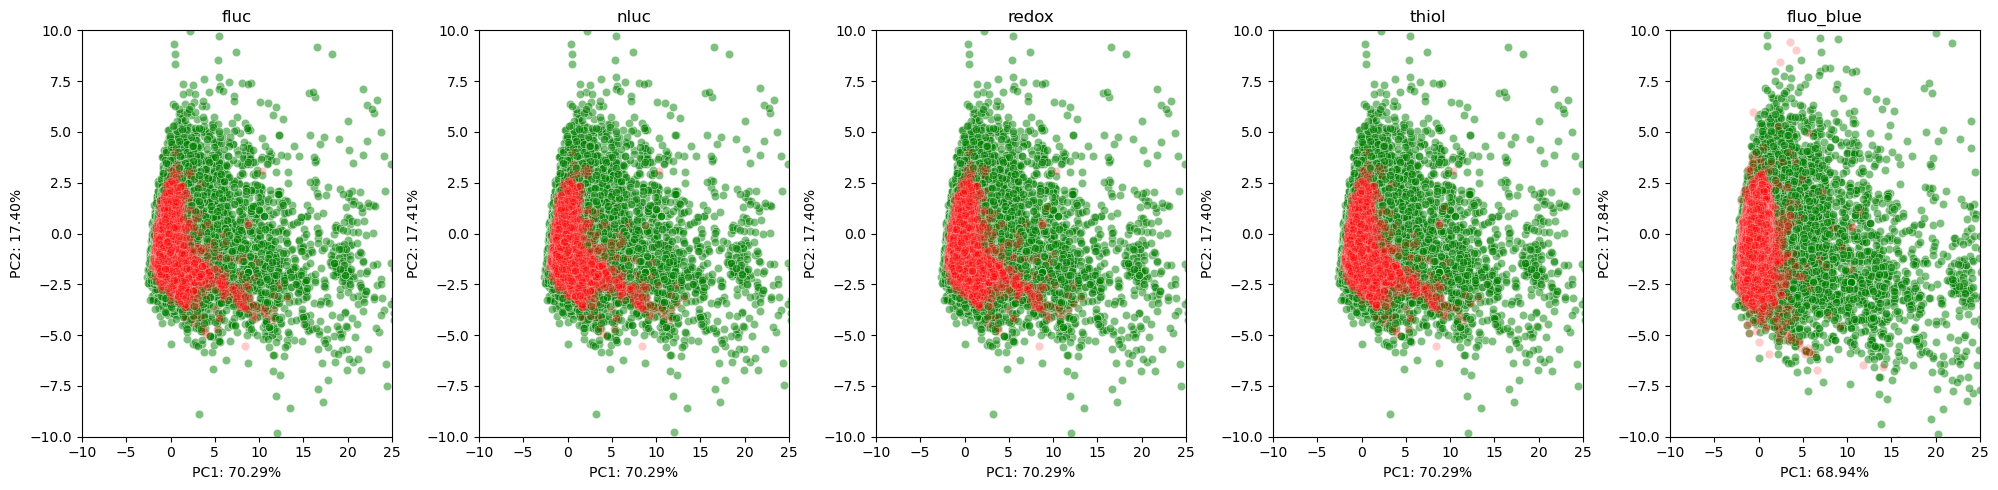

In [47]:
# Plot the PCAs and color based on the dataset.
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
clip_range = [(-10, 25), (-10, 10)] # Clip the density plot to this range.
for idx, (i, j) in enumerate(pcas.items()):
    sns.scatterplot(x=j[len(training_data[i]) :, 0], y=j[len(training_data[i]) :, 1], ax=ax[idx], color="green", markers="x", alpha=0.5);
    sns.scatterplot(x=j[: len(training_data[i]), 0], y=j[: len(training_data[i]), 1], ax=ax[idx], color="red", markers="x", alpha=0.2);


    ax[idx].set_title(i)
    ax[idx].set_xlabel("PC1: {:.2f}%".format(explained_variance[i][0] * 100))
    ax[idx].set_ylabel("PC2: {:.2f}%".format(explained_variance[i][1] * 100))
    ax[idx].set_xlim(clip_range[0])
    ax[idx].set_ylim(clip_range[1])

plt.tight_layout()

    

#### Compute DrugBank PCA

In [48]:
# Stack dataframes
concat_drugbank_physchem = {}
for i, j in training_physchem.items():
    concat_drugbank_physchem[i] = np.vstack([j.to_numpy(), drugbank.to_numpy()])

In [49]:
# Compute PCAs for each dataset.
pcas = {}
explained_variance = {}
for i, j in concat_drugbank_physchem.items():
    scaler = StandardScaler()
    j = scaler.fit_transform(j)
    pca = PCA(n_components=j.shape[1])
    pcas[i] = pca.fit_transform(j)
    explained_variance[i] = pca.explained_variance_ratio_

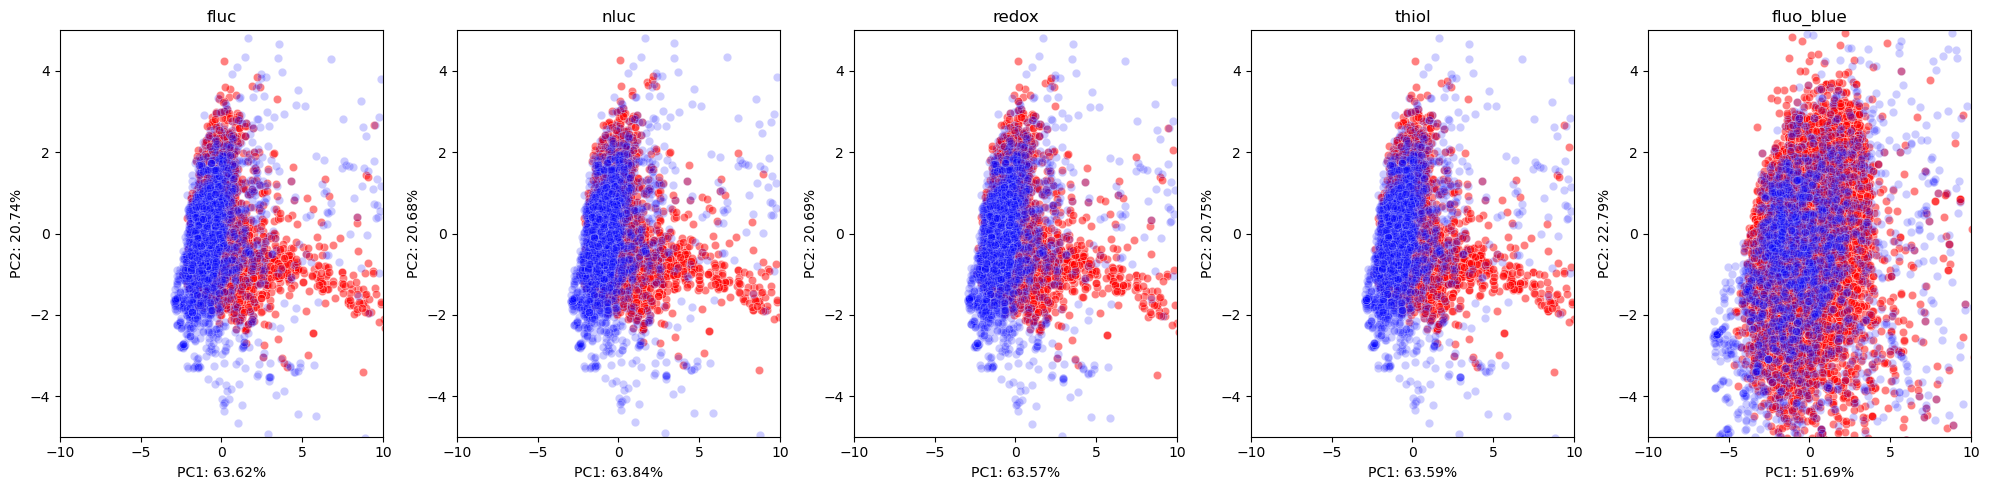

In [52]:
# Plot the PCAs and color based on the dataset.
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
clip_range = [(-10, 10), (-5, 5)] # Clip the density plot to this range.
for idx, (i, j) in enumerate(pcas.items()):
    sns.scatterplot(x=j[: len(training_data[i]), 0], y=j[: len(training_data[i]), 1], ax=ax[idx], color="red", markers="x", alpha=0.5);
    sns.scatterplot(x=j[len(training_data[i]) :, 0], y=j[len(training_data[i]) :, 1], ax=ax[idx], color="blue", markers="x", alpha=0.2);


    ax[idx].set_title(i)
    ax[idx].set_xlabel("PC1: {:.2f}%".format(explained_variance[i][0] * 100))
    ax[idx].set_ylabel("PC2: {:.2f}%".format(explained_variance[i][1] * 100))
    ax[idx].set_xlim(clip_range[0])
    ax[idx].set_ylim(clip_range[1])

plt.tight_layout()
    